# Neuromorphic Spiking Neural Network Classifier

This notebook explores neuromorphic computing using spiking neural networks (SNNs). We define a deep learning model that processes information using biologically inspired neurons. The network learns to classify images from the MNIST dataset by encoding them into spike trains using different encoding methods (rate, time, and delta coding).

The notebook aims to compare effectivness of different encoding schemas for spking neural networks.

This serves as a hands-on implementation of spiking neural networks for image classification, leveraging PyTorch and snnTorch. 🚀🔬

## Imports

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import snntorch as snn
from snntorch import spikegen
from snntorch import surrogate
from snntorch.functional.acc import accuracy_rate
from snntorch.functional.acc import accuracy_temporal
from snntorch.functional.loss import SpikeTime
from snntorch.functional.loss import ce_count_loss
from snntorch.functional.loss import ce_temporal_loss
import snntorch.spikeplot as splt
from IPython.display import HTML
import medmnist
from medmnist import INFO
from torch.utils.data import DataLoader
from medmnist import PneumoniaMNIST

## Variables

In [2]:
BATCH_SIZE = 64
IMAGE_REPITIONS = 4
EPOCHS = 30
SPIKE_GRAD = surrogate.fast_sigmoid(slope=25) #
BETA = 0.5
NUM_STEPS = 10
GAIN = 0.3
THRESHOLD_LATENCY = 1e-4
TAU = 0.9
THRESHOLD_DELTA = 0.5
NUM_CLASSES = 2

## Data

In [3]:
data_flag = 'pneumoniamnist'
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# Define transformation
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load train and test sets
train_dataset = DataClass(split='train', transform=transform, download=True)
test_dataset  = DataClass(split='test', transform=transform, download=True)
train_dataset = PneumoniaMNIST(split="train", transform=transform, download=True, size=64)
test_dataset = PneumoniaMNIST(split="test", transform=transform, download=True, size=64)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

images, labels = next(iter(train_loader))
print(f"Image shape: {images.shape}")
print(f"Label shape: {labels.shape}")

Image shape: torch.Size([64, 1, 64, 64])
Label shape: torch.Size([64, 1])


In [4]:
images, labels = next(iter(train_loader))
print(images.shape)
print(labels.shape)

torch.Size([64, 1, 64, 64])
torch.Size([64, 1])


In [5]:
image, label = next(iter(train_loader))
print(image.shape)

torch.Size([64, 1, 64, 64])


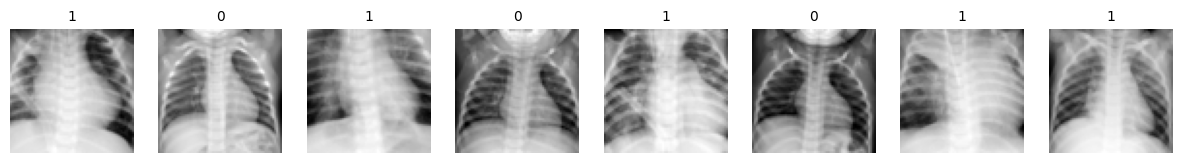

In [6]:
def plot_example(imgs, class_labels, num_images=10):
    '''
    Plots a sample of images along with their corresponding class labels.

    Parameters:
    imgs (torch.Tensor): A tensor of images with shape (N, C, H, W).
    class_labels (torch.Tensor): A tensor containing class labels corresponding to each image.
    num_images (int, optional): The number of images to display. Defaults to 10.

    Returns:
    None
    '''
    imgs = imgs[:num_images]
    class_labels = class_labels[:num_images]
    imgs = imgs.numpy().transpose((0, 2, 3, 1))

    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        axes[i].imshow(imgs[i], cmap='gray')
        axes[i].axis("off")
        axes[i].set_title(class_labels[i].item(), fontsize=10)

    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
plot_example(images, labels, num_images=8)

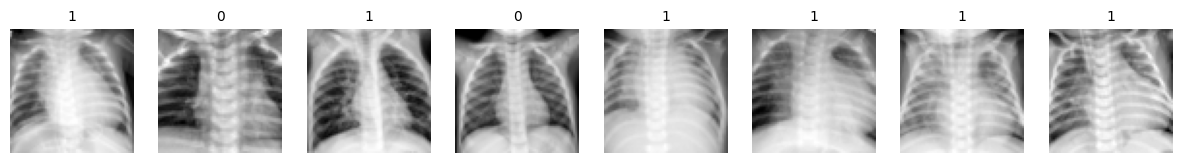

In [7]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
plot_example(images, labels, num_images=8)

## Rate encoding

Description via: https://snntorch.readthedocs.io/en/latest/index.html

One example of converting input data into a rate code is as follows.
Each normalised input feature $X_{ij}$ is used as the probability an event (spike) occurs at any given time step, returning a rate-coded value $R_{ij}$. This can be treated as a Bernoulli trial: $R_{ij}\sim B(n,p)$, where the number of trials is $n=1$, and the probability of success (spiking) is $p=X_{ij}$. Explicitly, the probability a spike occurs is:

$${\rm P}(R_{ij}=1) = X_{ij} = 1 - {\rm P}(R_{ij} = 0)$$

For an MNIST image, this probability of spiking corresponds to the pixel value. A white pixel corresponds to a 100% probability of spiking, and a black pixel will never generate a spike.

In [4]:
spike_data = spikegen.rate(images, num_steps=NUM_STEPS, gain=GAIN)

GAIN = 0.5
spike_data_sample2 = spike_data[:, 0, 0]

## Latency Encoding

Description via: https://snntorch.readthedocs.io/en/latest/index.html

Temporal codes capture information about the precise firing time of neurons; a single spike carries much more meaning than in rate codes which rely on firing frequency. While this opens up more susceptibility to noise, it can also decrease the power consumed by the hardware running SNN algorithms by orders of magnitude.

`spikegen.latency` is a function that allows each input to fire at most **once** during the full time sweep.
Features closer to `1` will fire earlier and features closer to `0` will fire later. I.e., in our MNIST case, bright pixels will fire earlier and dark pixels will fire later.

In [5]:
spike_data = spikegen.latency(images, num_steps=NUM_STEPS, tau=TAU, threshold=THRESHOLD_LATENCY)

spike_data_sample2 = spike_data[:, 0, 0]

## Delta Encoding

Description via: https://snntorch.readthedocs.io/en/latest/index.html

Delta modulation is based on event-driven spiking. The `snntorch.delta` function accepts a time-series tensor as input. It takes the difference between each subsequent feature across all time steps. By default, if the difference is both *positive* and *greater than the threshold $V_{thr}$*, a spike is generated.

In our case, to make the example suitable for the delta encoding we can use the raet encoding and then the delta encoding on the output to generate the time-series encoding.

In [6]:
spike_data = spikegen.delta(spikegen.rate(images, num_steps=NUM_STEPS, gain=GAIN), threshold=THRESHOLD_DELTA, off_spike=True)

spike_data_sample2 = spike_data[:, 0, 0]

## Model

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import snntorch as snn
import pennylane as qml

# Assuming you have defined BETA, SPIKE_GRAD, BATCH_SIZE, NUM_CLASSES, and images.shape elsewhere
# For demonstration purposes, I'll define them here:
BETA = 0.9
SPIKE_GRAD = snn.surrogate.fast_sigmoid()
BATCH_SIZE = 64
NUM_CLASSES = 2

# Quantum Layer using PennyLane
class QuantumLayer(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.n_qubits = input_size  # Assuming input_size qubits
        self.dev = qml.device("default.qubit", wires=self.n_qubits)

        def circuit(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=range(self.n_qubits))
            qml.templates.BasicEntanglerLayers(weights, wires=range(self.n_qubits))
            return [qml.expval(qml.PauliZ(i)) for i in range(self.n_qubits)]

        self.qnode = qml.QNode(circuit, self.dev, interface="torch")
        self.weight_shapes = {"weights": (6, self.n_qubits)}  # Adjust as needed
        self.qlayer = qml.qnn.TorchLayer(self.qnode, self.weight_shapes)

    def forward(self, x):
        return self.qlayer(x)

class Neuromorphic_Net(nn.Module):
    '''
    A spiking neural network (SNN) model using leaky integrate-and-fire (LIF) neurons
    with an integrated Quantum Layer before the final spiking layer.

    Parameters:
    input_shape (tuple): Shape of the input data (batch_size, channels, height, width).
    num_classes (int): Number of output classes for classification.

    Attributes:
    conv1 (nn.Conv2d): First convolutional layer.
    lif1 (snn.Leaky): First LIF layer.
    conv2 (nn.Conv2d): Second convolutional layer.
    lif2 (snn.Leaky): Second LIF layer.
    conv3 (nn.Conv2d): Third convolutional layer.
    lif3 (snn.Leaky): Third LIF layer.
    quantum (QuantumLayer): Quantum layer.
    output (nn.Linear): Fully connected output layer.
    lif4 (snn.Leaky): Fourth LIF layer.

    Methods:
    get_covnolution_output(): Computes the flattened output size after convolutional layers.
    reset_states(): Resets the membrane potentials of LIF layers.
    forward(x): Performs a forward pass through the network.

    Returns:
    torch.Tensor: Output spike activity of the final layer.
    '''
    def __init__(self, input_shape, num_classes):
        super().__init__()
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.in_channels = input_shape[1]
        self.conv1 = nn.Conv2d(self.in_channels, 4, 3)
        self.lif1 = snn.Leaky(beta=BETA, spike_grad=SPIKE_GRAD)
        self.conv2 = nn.Conv2d(4, 8, 3)
        self.lif2 = snn.Leaky(beta=BETA, spike_grad=SPIKE_GRAD)
        self.conv3 = nn.Conv2d(8, 16, 3)
        self.lif3 = snn.Leaky(beta=BETA, spike_grad=SPIKE_GRAD)

        conv_output_size = self.get_covnolution_output()
        self.linear = nn.Linear(conv_output_size, 4)
        self.quantum = QuantumLayer(4, 4) #Make sure input and output size of quantum layer are equal.
        self.output = nn.Linear(4, 2)
        self.lif4 = snn.Leaky(beta=BETA, spike_grad=SPIKE_GRAD)

    def get_covnolution_output(self):
        dummy_input = torch.rand(*self.input_shape)
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        cur1 = F.max_pool2d(self.conv1(dummy_input), 2)
        spk1, mem1 = self.lif1(cur1, mem1)
        cur2 = F.max_pool2d(self.conv2(spk1), 2)
        spk2, mem2 = self.lif2(cur2, mem2)
        cur3 = F.max_pool2d(self.conv3(spk2), 2)
        spk3, mem3 = self.lif3(cur3, mem3)
        output_shape = spk3.shape[1]*spk3.shape[2]*spk3.shape[3]
        return output_shape

    def reset_states(self):
        self.mem1 = self.lif1.init_leaky()
        self.mem2 = self.lif2.init_leaky()
        self.mem3 = self.lif3.init_leaky()
        self.mem4 = self.lif4.init_leaky()

    def forward(self, x):
        cur1 = F.max_pool2d(self.conv1(x), 2)
        spk1, self.mem1 = self.lif1(cur1, self.mem1)
        cur2 = F.max_pool2d(self.conv2(spk1), 2)
        spk2, self.mem2 = self.lif2(cur2, self.mem2)
        cur3 = F.max_pool2d(self.conv3(spk2), 2)
        spk3, self.mem3 = self.lif3(cur3, self.mem3)
        lin_output = self.linear(spk3.view((spk3.shape[0], spk3.shape[1]*spk3.shape[2]*spk3.shape[3])))
        quantum_output = self.quantum(lin_output)
        output = self.output(quantum_output)
        spk4, self.mem4 = self.lif4(output, self.mem4)
        return spk4


In [ ]:
model = Neuromorphic_Net(images.shape, NUM_CLASSES)
model.reset_states()
print(model)
print(model(torch.rand(64, *images[0].shape)).shape)
print(model(torch.rand(16, *images[0].shape)).shape)

num_parameters = 0
for parameter in model.parameters():
    num_parameters += parameter.detach().numpy().size

print(f"Number of Parameters: {num_parameters}")

In [8]:
def encode_rate(input):
    '''
    Encodes input data into spike trains using rate coding.

    Parameters:
    input (torch.Tensor): Input tensor to be encoded.

    Returns:
    torch.Tensor: Rate-encoded spike train.
    '''
    return spikegen.rate(input, num_steps=NUM_STEPS, gain=GAIN)

def encode_time(input):
    '''
    Encodes input data into spike trains using time-to-first-spike (latency) coding.

    Parameters:
    input (torch.Tensor): Input tensor to be encoded.

    Returns:
    torch.Tensor: Time-encoded spike train.
    '''
    return spikegen.latency(input, num_steps=NUM_STEPS, tau=TAU, threshold=THRESHOLD_LATENCY)

def encode_delta(input):
    '''
    Encodes input data using delta modulation, based on changes in rate-coded spikes.

    Parameters:
    input (torch.Tensor): Input tensor to be encoded.

    Returns:
    torch.Tensor: Delta-encoded spike train.
    '''
    return spikegen.delta(spikegen.rate(input, num_steps=NUM_STEPS, gain=GAIN), threshold=THRESHOLD_DELTA, off_spike=True)

def train(model, optimizer, criterion, dataset, encoding, accuracy_fn):
    '''
    Trains the Neuromorphic_Net model.

    Parameters:
    model (Neuromorphic_Net): The neural network model to be trained.
    optimizer (torch.optim.Optimizer): Optimizer for training the model.
    criterion (torch.nn.Module): Loss function used for training.
    dataset (torch.utils.data.DataLoader): Training dataset loader.
    encoding (function): Function for encoding input data into spike trains.
    accuracy_fn (function): Function to compute model accuracy.

    Returns:
    Neuromorphic_Net: The trained model.
    '''
    model.train()
    for epoch in range(EPOCHS):
        total_loss = 0.0
        total_accuracy = 0.0
        for imgs, labels in dataset:
            inputs_temporal = encoding(imgs)
            optimizer.zero_grad()
            outputs = []
            model.reset_states()
            labels = labels.reshape(-1)
            for inputs in inputs_temporal:
                outputs_step = model(inputs)
                outputs.append(outputs_step)
            outputs = torch.stack(outputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_accuracy += accuracy_fn(outputs, labels)
        print(f"Epoch {epoch}: Loss: {total_loss/len(dataset):.4f} Accuracy: {total_accuracy/len(dataset):.4f}")
    return model

def test(model, criterion, dataset, encoding, accuracy_fn):
    '''
    Evaluates the Neuromorphic_Net model on a test dataset.

    Parameters:
    model (Neuromorphic_Net): The trained neural network model.
    criterion (torch.nn.Module): Loss function used for evaluation.
    dataset (torch.utils.data.DataLoader): Test dataset loader.
    encoding (function): Function for encoding input data into spike trains.
    accuracy_fn (function): Function to compute model accuracy.

    Returns:
    None
    '''
    model.eval()
    total_loss = 0.0
    total_accuracy = 0.0
    for imgs, labels in dataset:
        labels = labels.reshape(-1)
        inputs_temporal = encoding(imgs)
        outputs = []
        model.reset_states()
        for inputs in inputs_temporal:
            with torch.no_grad():
                outputs_step = model(inputs)
            outputs.append(outputs_step)
        outputs = torch.stack(outputs)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        total_accuracy += accuracy_fn(outputs, labels)
    print(f"Test Loss: {total_loss/len(dataset):.4f} Test Accuracy: {total_accuracy/len(dataset):.4f}")

### Model - Rate

In [13]:
model = Neuromorphic_Net(images.shape, NUM_CLASSES)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = ce_count_loss(population_code=True, num_classes=NUM_CLASSES)
model = train(model, optimizer, loss_fn, train_loader, encode_rate, accuracy_rate)
test(model, loss_fn, test_loader, encode_rate, accuracy_rate)

torch.save(model.state_dict(), "neuromorphic_rate_model.pth")
print("Model saved as neuromorphic_rate_model.pth")

Epoch 0: Loss: 0.7448 Accuracy: 0.2583
Epoch 1: Loss: 0.6931 Accuracy: 0.2580
Epoch 2: Loss: 0.6793 Accuracy: 0.3111
Epoch 3: Loss: 0.5035 Accuracy: 0.8207
Epoch 4: Loss: 0.3215 Accuracy: 0.8808
Epoch 5: Loss: 0.2508 Accuracy: 0.8958
Epoch 6: Loss: 0.2250 Accuracy: 0.9090
Epoch 7: Loss: 0.2123 Accuracy: 0.9126
Epoch 8: Loss: 0.2015 Accuracy: 0.9164
Epoch 9: Loss: 0.1936 Accuracy: 0.9185
Epoch 10: Loss: 0.1862 Accuracy: 0.9242
Epoch 11: Loss: 0.1911 Accuracy: 0.9230
Epoch 12: Loss: 0.1821 Accuracy: 0.9289
Epoch 13: Loss: 0.1780 Accuracy: 0.9264
Epoch 14: Loss: 0.1841 Accuracy: 0.9247
Epoch 15: Loss: 0.1764 Accuracy: 0.9256
Epoch 16: Loss: 0.1602 Accuracy: 0.9324
Epoch 17: Loss: 0.1711 Accuracy: 0.9280
Epoch 18: Loss: 0.1611 Accuracy: 0.9346
Epoch 19: Loss: 0.1669 Accuracy: 0.9331
Epoch 20: Loss: 0.1627 Accuracy: 0.9332
Epoch 21: Loss: 0.1547 Accuracy: 0.9378
Epoch 22: Loss: 0.1534 Accuracy: 0.9394
Epoch 23: Loss: 0.1483 Accuracy: 0.9415
Epoch 24: Loss: 0.1560 Accuracy: 0.9398
Epoch 25: 

## Training plot

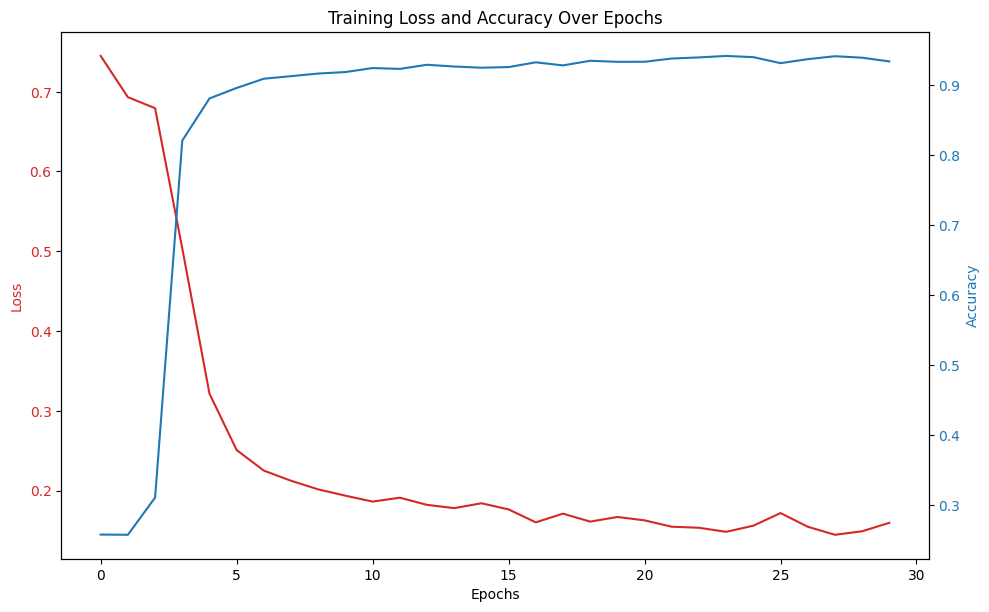

In [ ]:
epochs = list(range(30))
losses = [
    0.7448, 0.6931, 0.6793, 0.5035, 0.3215, 0.2508, 0.2250, 0.2123, 0.2015, 0.1936, 0.1862, 0.1911, 0.1821, 0.1780, 
    0.1841, 0.1764, 0.1602, 0.1711, 0.1611, 0.1669, 0.1627, 0.1547, 0.1534, 0.1483, 0.1560, 0.1718, 0.1547, 0.1446, 
    0.1490, 0.1596
]
accuracies = [
    0.2583, 0.2580, 0.3111, 0.8207, 0.8808, 0.8958, 0.9090, 0.9126, 0.9164, 0.9185, 0.9242, 0.9230, 0.9289, 0.9264, 
    0.9247, 0.9256, 0.9324, 0.9280, 0.9346, 0.9331, 0.9332, 0.9378, 0.9394, 0.9415, 0.9398, 0.9312, 0.9369, 0.9411, 
    0.9390, 0.9337
]

# Plotting accuracy and loss
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot loss on the left axis
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='tab:red')
ax1.plot(epochs, losses, color='tab:red', label='Loss')
ax1.tick_params(axis='y', labelcolor='tab:red')

# Create a second y-axis to plot accuracy
ax2 = ax1.twinx()  
ax2.set_ylabel('Accuracy', color='tab:blue')  
ax2.plot(epochs, accuracies, color='tab:blue', label='Accuracy')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Title and layout
fig.tight_layout()  
plt.title('Training Loss and Accuracy Over Epochs')
plt.show()

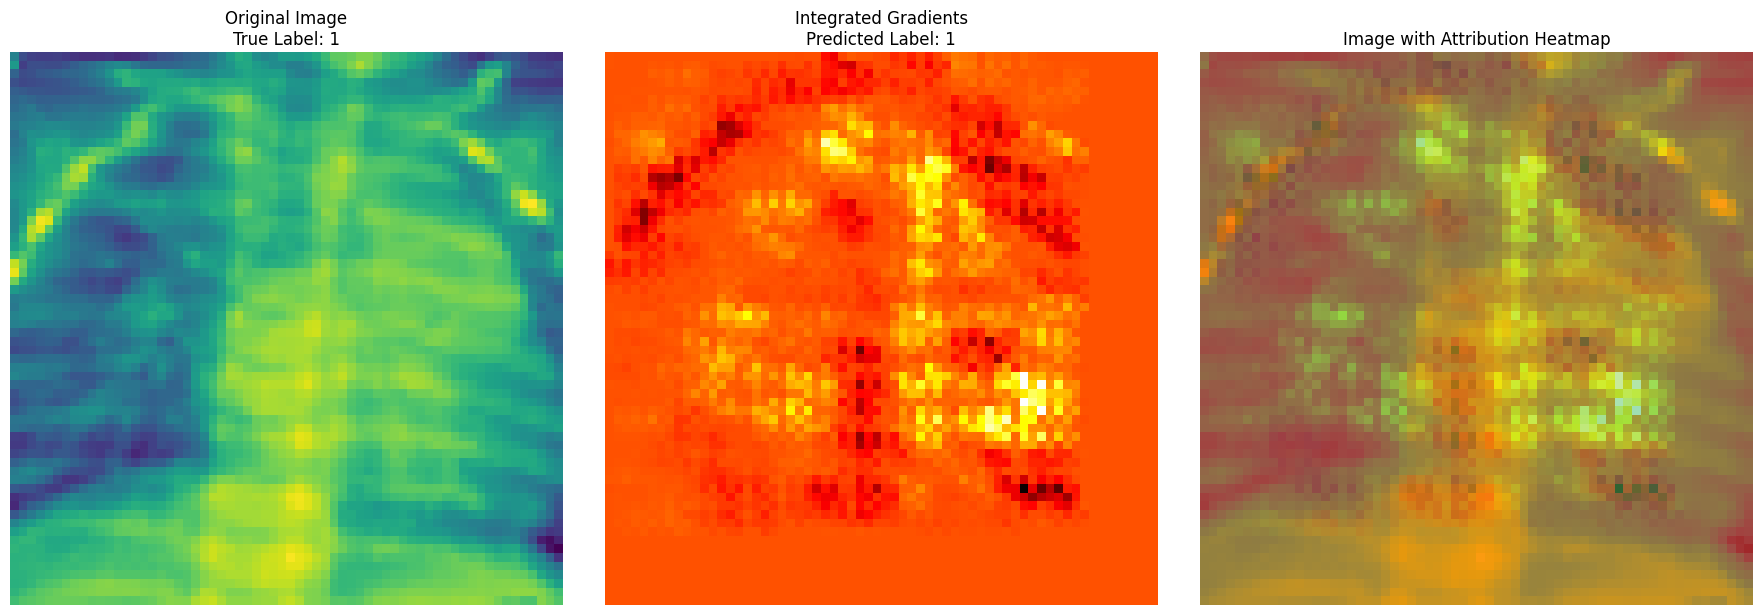

In [238]:
from captum.attr import IntegratedGradients

def visualize_integrated_gradients(model, input_image, true_label):
    ig = IntegratedGradients(model)
    
    model.eval()
    
    attributions, delta = ig.attribute(input_image, target=true_label, return_convergence_delta=True)
    
    # Get the model's prediction
    with torch.no_grad():
        output = model(input_image)
        predicted_label = output.argmax(dim=1).item()  # Get the predicted label (index of max logit)

    # Convert the attributions to numpy and squeeze the batch dimension
    attributions = attributions.squeeze().cpu().detach().numpy()
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].imshow(input_image.squeeze().cpu().detach().numpy())  # Transpose for (H, W, C)
    axes[0].set_title(f"Original Image\nTrue Label: {true_label}")
    axes[0].axis('off')
    
    im = axes[1].imshow(attributions, cmap='hot')
    axes[1].set_title(f"Integrated Gradients\nPredicted Label: {predicted_label}")
    axes[1].axis('off')
    # fig.colorbar(im, ax=axes[1])
    
    axes[2].imshow(input_image.squeeze().cpu().detach().numpy())
    axes[2].imshow(attributions, cmap='hot', alpha=0.5)  # Overlay attribution heatmap
    axes[2].set_title(f"Image with Attribution Heatmap")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
# Pick an image from the test dataset (e.g., index 0)
i = 35
test_image, test_label = next(iter(test_loader))
test_image = test_image[i:i+1]  # Take the first image from the batch
true_label = test_label[i].item()  # True label for the image

visualize_integrated_gradients(model, test_image, true_label)

# Saliency maps

In [9]:
from captum.attr import Saliency

c:\Users\Bartek\anaconda3\envs\qlfuture\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
class WrappedModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.model.reset_states()

    def forward(self, x):
        # Captum expects batched input, e.g. (B, C, H, W)
        return self.model(x)


In [11]:
data_flag = 'pneumoniamnist'
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# Define transformation
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load train and test sets
train_dataset = DataClass(split='train', transform=transform, download=True)
test_dataset  = DataClass(split='test', transform=transform, download=True)
train_dataset = PneumoniaMNIST(split="train", transform=transform, download=True, size=64)
test_dataset = PneumoniaMNIST(split="test", transform=transform, download=True, size=64)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

images, labels = next(iter(train_loader))
print(f"Image shape: {images.shape}")
print(f"Label shape: {labels.shape}")

Image shape: torch.Size([64, 1, 64, 64])
Label shape: torch.Size([64, 1])


In [12]:
model = Neuromorphic_Net(images.shape, NUM_CLASSES)
model.load_state_dict(torch.load("../models/quantum_neuromorphic_rate_model.pth"))
model.eval()
print("Model loaded.")

Model loaded.


C:\Users\Bartek\AppData\Local\Temp\ipykernel_14044\3960014713.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  attributions = saliency.attribute(rate_encoded, target=int(label))


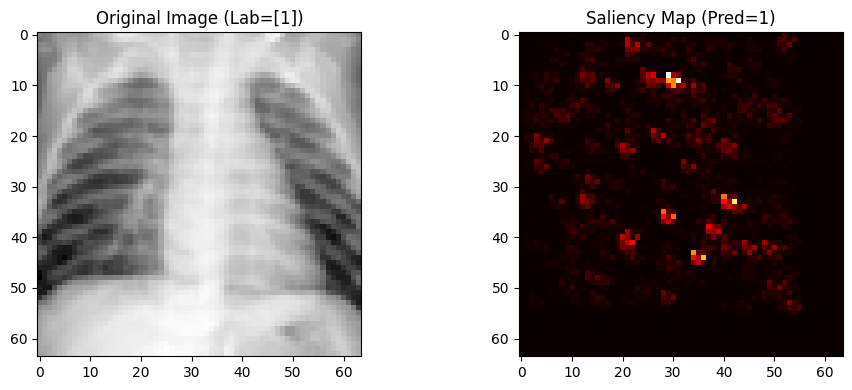

In [174]:
# Choose one image
img, label = test_dataset[74]
input_tensor = img.unsqueeze(0).requires_grad_()  # Add batch dim

# Convert image to rate-encoded spike at t=0
rate_encoded = encode_rate(input_tensor)[0]  # shape: (B, C, H, W)

# Wrap model for Captum
wrapped_model = WrappedModel(model)

# Apply Captum's Saliency
saliency = Saliency(wrapped_model)
attributions = saliency.attribute(rate_encoded, target=int(label))

# Get predicted label
output = model(rate_encoded.unsqueeze(0)[0])  # Ensure batch dimension is there
predicted_label = output.argmax(dim=1).item()  # Get the predicted label (index of max output)

# Convert to numpy
attr_np = attributions.squeeze().detach().numpy()

# Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title(f"Original Image (Lab={label})")
plt.imshow(img.squeeze(), cmap="gray")

plt.subplot(1, 2, 2)
plt.title(f"Saliency Map (Pred={predicted_label})")
plt.imshow(attr_np, cmap="hot")  # Assuming 1 channel
plt.tight_layout()
plt.show()


C:\Users\Bartek\AppData\Local\Temp\ipykernel_14044\2157358902.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  attributions = saliency.attribute(rate_encoded, target=int(label))


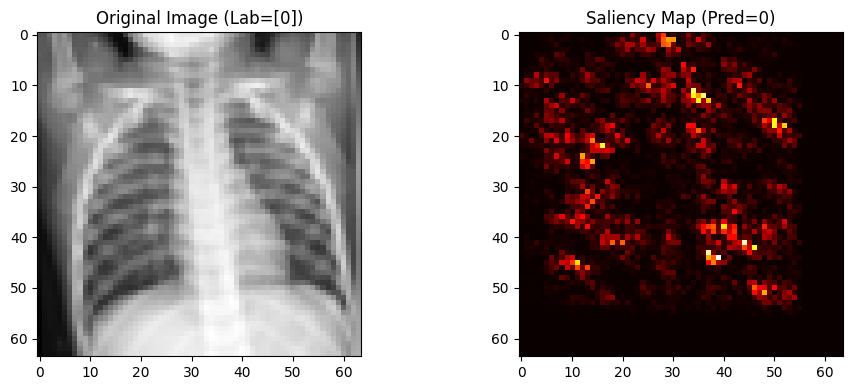

In [161]:
# Choose one image
img, label = test_dataset[20]
input_tensor = img.unsqueeze(0).requires_grad_()  # Add batch dim

# Convert image to rate-encoded spike at t=0
rate_encoded = encode_rate(input_tensor)[0]  # shape: (B, C, H, W)

# Wrap model for Captum
wrapped_model = WrappedModel(model)

# Apply Captum's Saliency
saliency = Saliency(wrapped_model)
attributions = saliency.attribute(rate_encoded, target=int(label))

# Get predicted label
output = model(rate_encoded.unsqueeze(0)[0])  # Ensure batch dimension is there
predicted_label = output.argmax(dim=1).item()  # Get the predicted label (index of max output)

# Convert to numpy
attr_np = attributions.squeeze().detach().numpy()

# Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title(f"Original Image (Lab={label})")
plt.imshow(img.squeeze(), cmap="gray")

plt.subplot(1, 2, 2)
plt.title(f"Saliency Map (Pred={predicted_label})")
plt.imshow(attr_np, cmap="hot")  # Assuming 1 channel
plt.tight_layout()
plt.show()
